# Shakespeare Transformer - Interactive CapstoneComplete end-to-end training of a character-level transformer on Shakespeare text.**What You'll Learn:**- Data preparation and tokenization- Model configuration and training- Text generation with different sampling strategies- Model evaluation and analysis**Time**: ~10-15 minutes (on GPU/Colab with reduced steps)[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shiong-tan/tiny-transformer-build/blob/master/docs/modules/09_capstone/notebook.ipynb)

## 1. Setup & Installation

Install dependencies and setup environment.

In [1]:
# Verify PyTorch
import torch
import sys
from pathlib import Path

print(f'Python: {sys.version}')
print(f'PyTorch: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'Device: {"cuda" if torch.cuda.is_available() else "cpu"}')

# Add project to path (if running locally)
if Path('../../../tiny_transformer').exists():
    sys.path.insert(0, str(Path.cwd().parent.parent.parent))
    print('✓ Running locally')
else:
    print('Note: Adjust paths for your environment')

Python: 3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 17.0.0 (clang-1700.3.19.1)]
PyTorch: 2.9.1
CUDA available: False
Device: cpu
✓ Running locally


## 2. Data Preparation

Download and analyze the Shakespeare dataset.

In [2]:
# Load Shakespeare dataset
import os
import urllib.request

data_path = '../../../data/tiny_shakespeare.txt'

# Download if not exists
if not os.path.exists(data_path):
    print('Downloading Shakespeare dataset...')
    os.makedirs(os.path.dirname(data_path), exist_ok=True)
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    urllib.request.urlretrieve(url, data_path)
    print('✓ Download complete')

with open(data_path, 'r') as f:
    text = f.read()

print(f'Total characters: {len(text):,}')
print(f'Total lines: {text.count(chr(10)):,}')
print(f'Vocabulary size: {len(set(text))}')
print(f'\nFirst 500 characters:')
print(text[:500])

Total characters: 1,115,394
Total lines: 40,000
Vocabulary size: 65

First 500 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


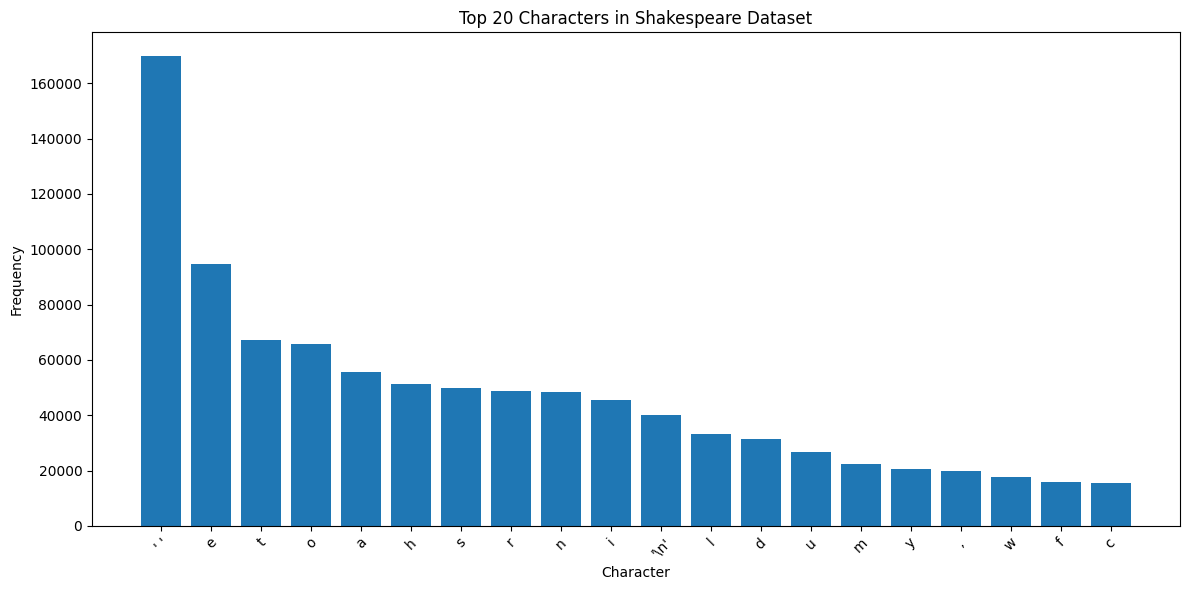

In [3]:
# Character distribution analysis
from collections import Counter
import matplotlib.pyplot as plt

char_counts = Counter(text)
top_chars = char_counts.most_common(20)

chars = [repr(c) if c in ['\n', '\t', ' '] else c for c, _ in top_chars]
counts = [count for _, count in top_chars]

plt.figure(figsize=(12, 6))
plt.bar(chars, counts)
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.title('Top 20 Characters in Shakespeare Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Tokenization

Create character-level tokenizer.

In [4]:
from tiny_transformer.training import CharTokenizer

# Create and fit tokenizer
tokenizer = CharTokenizer()
tokenizer.fit(text)

print(f'Vocabulary size: {tokenizer.vocab_size}')
print(f'\nFirst 10 vocab items:')
for char, idx in list(tokenizer.vocab.items())[:10]:
    print(f'  {repr(char)}: {idx}')

Vocabulary size: 65

First 10 vocab items:
  '\n': 0
  ' ': 1
  '!': 2
  '$': 3
  '&': 4
  "'": 5
  ',': 6
  '-': 7
  '.': 8
  '3': 9


In [5]:
# Test encoding/decoding
test_text = 'ROMEO: What say you?'
tokens = tokenizer.encode(test_text)
decoded = tokenizer.decode(tokens)

print(f'Original: {test_text}')
print(f'Tokens: {tokens}')
print(f'Decoded: {decoded}')
print(f'Match: {test_text == decoded}')

Original: ROMEO: What say you?
Tokens: [30, 27, 25, 17, 27, 10, 1, 35, 46, 39, 58, 1, 57, 39, 63, 1, 63, 53, 59, 12]
Decoded: ROMEO: What say you?
Match: True


## 4. Model Configuration

Setup model and training configuration.

In [6]:
from tiny_transformer.model import TinyTransformerLM

# Model configuration (smaller for faster training)
config = {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'n_heads': 4,
    'n_layers': 4,
    'd_ff': 1024,
    'max_len': 128,  # Correct parameter name for TinyTransformerLM
    'dropout': 0.1,
    'tie_weights': True,
}

# Create model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TinyTransformerLM(**config).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f'Model parameters: {num_params:,}')
print(f'Device: {device}')

Model parameters: 3,176,192
Device: cpu


## 5. Training Setup

Prepare datasets and training components.

In [7]:
from tiny_transformer.training import TextDataset
from torch.utils.data import DataLoader

# Tokenize full text
tokens = tokenizer.encode(text)

# Split train/val (90/10)
val_size = len(tokens) // 10
train_tokens = tokens[:-val_size]
val_tokens = tokens[-val_size:]

print(f'Train tokens: {len(train_tokens):,}')
print(f'Val tokens: {len(val_tokens):,}')

# Create datasets
train_dataset = TextDataset(train_tokens, seq_len=128, stride=64)
val_dataset = TextDataset(val_tokens, seq_len=128, stride=128)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Train batches: {len(train_loader)}')
print(f'Val batches: {len(val_loader)}')

Train tokens: 1,003,855
Val tokens: 111,539
Train batches: 491
Val batches: 28


In [8]:
from tiny_transformer.training import Trainer, TrainerConfig, WarmupCosineScheduler

# Training configuration
trainer_config = TrainerConfig(
    learning_rate=1e-3,
    weight_decay=0.01,
    grad_clip=1.0,
    warmup_steps=200,
    max_steps=2000,
    eval_interval=200,
    log_interval=50,
    device=device,
)

# Create trainer
trainer = Trainer(model, train_loader, val_loader, trainer_config)

# Setup scheduler
scheduler = WarmupCosineScheduler(
    optimizer=trainer.optimizer,
    warmup_steps=trainer_config.warmup_steps,
    total_steps=trainer_config.max_steps,
    peak_lr=trainer_config.learning_rate,
    min_lr=1e-5,
)
trainer.scheduler = scheduler

print('Training setup complete!')

Training setup complete!


## 6. Training

Train the model (this will take ~10-15 minutes on GPU).

In [ ]:
# Train with progress tracking
import time

print('='*70)
print('Starting Training')
print('='*70)

start_time = time.time()

try:
    metrics = trainer.train()
    
    elapsed = time.time() - start_time
    print(f'\nTraining complete in {elapsed/60:.1f} minutes')
    print(f'Final train loss: {metrics.get("train_loss", 0):.3f}')
    print(f'Final val loss: {metrics.get("val_loss", 0):.3f}')
    
except KeyboardInterrupt:
    print('\nTraining interrupted')

Starting Training
Starting Training
Device: cpu
Training samples: 15684
Validation samples: 871
Config: TrainerConfig(learning_rate=0.001, weight_decay=0.01, betas=(0.9, 0.95), grad_clip=1.0, log_interval=50, eval_interval=200, save_interval=1000, max_steps=2000, num_epochs=10, warmup_steps=200, device='cpu', checkpoint_dir='checkpoints', pad_token_id=None)

Epoch 0 | Step 50 | Loss: 3.3098 | PPL: 27.38 | LR: 2.50e-04 | Grad: 0.33
Epoch 0 | Step 100 | Loss: 2.6363 | PPL: 13.96 | LR: 5.00e-04 | Grad: 0.51
Epoch 0 | Step 150 | Loss: 2.5284 | PPL: 12.53 | LR: 7.50e-04 | Grad: 0.42
Epoch 0 | Step 200 | Loss: 2.4048 | PPL: 11.08 | LR: 1.00e-03 | Grad: 0.47
  Validation | Loss: 2.3773 | PPL: 10.78
  Saved checkpoint: checkpoints/best.pt
  ✓ New best model! Val loss: 2.3773
Epoch 0 | Step 250 | Loss: 1.9213 | PPL: 6.83 | LR: 9.98e-04 | Grad: 0.88
Epoch 0 | Step 300 | Loss: 0.7861 | PPL: 2.19 | LR: 9.92e-04 | Grad: 1.08
Epoch 0 | Step 350 | Loss: 0.2108 | PPL: 1.23 | LR: 9.83e-04 | Grad: 0.94


## 7. Text Generation

Generate Shakespeare-style text with the trained model.

In [ ]:
from tiny_transformer.sampling import TextGenerator, GeneratorConfigdef generate(prompt, temperature=0.8, max_tokens=100):    """Generate text from prompt."""    # Ensure we don't exceed model's max_len (128)    # Leave room for prompt by capping max_tokens    max_tokens = min(max_tokens, 120 - len(tokenizer.encode(prompt)))        gen_config = GeneratorConfig(        max_new_tokens=max_tokens,        temperature=temperature,        top_p=0.95,        do_sample=True,    )        generator = TextGenerator(model, gen_config, device=device)        model.eval()    prompt_tokens = torch.tensor([tokenizer.encode(prompt)]).to(device)        with torch.no_grad():        output_tokens = generator.generate(prompt_tokens)        return tokenizer.decode(output_tokens[0].tolist())# Generate sampleprompt = 'ROMEO:'generated = generate(prompt)print('='*70)print(f'Prompt: {prompt}')print('-'*70)print(generated)print('='*70)

## 8. Compare Sampling Strategies

Experiment with different sampling parameters.

In [ ]:
# Compare different temperatures
prompt = 'HAMLET:'
temperatures = [0.5, 0.8, 1.2]

for temp in temperatures:
    print(f'\nTemperature: {temp}')
    print('-'*70)
    generated = generate(prompt, temperature=temp, max_tokens=100)
    print(generated)
    print('-'*70)

## 9. Interactive Generation

Try your own prompts!

In [ ]:
# Interactive cell - run multiple times with different promptsyour_prompt = 'JULIET:'  # Change this!temperature = 0.8  # Adjust creativitymax_tokens = 100  # Length (capped to fit model's max_len)result = generate(your_prompt, temperature, max_tokens)print(result)

## 10. Save Model

Save the trained model for later use.

In [ ]:
# Save checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'config': config,
    'tokenizer_vocab': tokenizer.vocab,
}

torch.save(checkpoint, 'shakespeare_model.pt')
print('✓ Model saved to shakespeare_model.pt')

## Congratulations!

You've successfully trained a character-level transformer on Shakespeare!

**What you learned:**
- Data preparation and tokenization
- Model architecture and configuration
- Training loop with validation
- Text generation with sampling strategies

**Next steps:**
1. Train longer (20k steps) for better quality
2. Try different model sizes (d_model=384, n_layers=6)
3. Fine-tune on your own text data
4. Experiment with advanced sampling (beam search, nucleus sampling)

See `docs/modules/09_capstone/walkthrough.md` for the complete guide!